In [1]:
import numpy as np
import scipy.signal as signal
%matplotlib notebook
import matplotlib.pyplot as plt

# Double Soft Clipping Nonlinearity

While measuring a tape machine the other day, I noticed that when overdriving the input gain circuit, I got back a pretty interesting non-linear response that looked something like this:
<img src="Gain Nonlinearity.png" width="60%">

The nonlinearity looks likes a mix of two classic nonlinearities in audio signal processing, exhibiting a "saturating" characteristic for large input, and a "dropout" nonlinearity for small input. It's hard to say exactly why the circuit has this response. The tape machine does claim to have some sort of "automatic gain control" on the input to mitigate clipping, so that could be relevant, but the tape machine is also fairly old, and the odd response could simply be a result of age, or something being broken internally. Without taking the machine apart, it's difficult to know more.

Anyhow, this measurement gave me an idea for a new type of musical nonlinearity: the Double Soft Clipper.

## Implementation

The Double Soft Clipper can be implemented as two soft clippers stacked on top of each other:

<IPython.core.display.Javascript object>


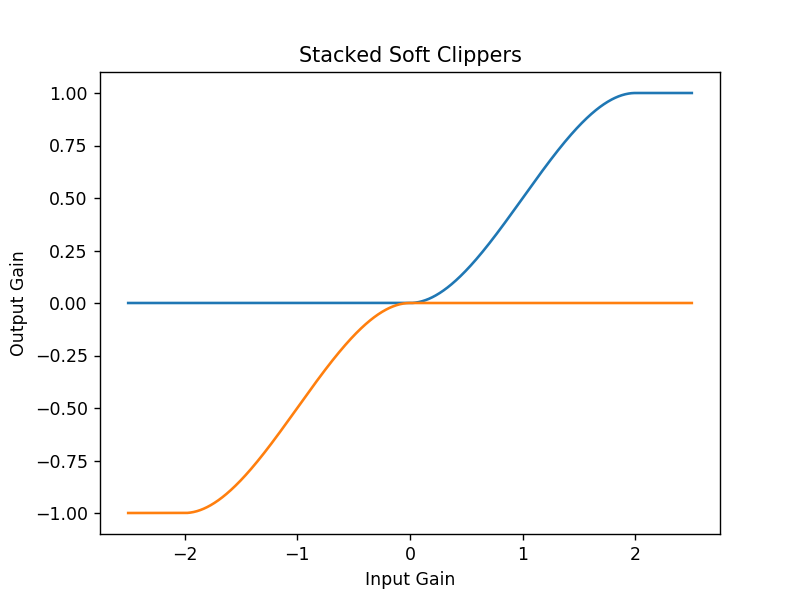

Text(0.5, 1.0, 'Stacked Soft Clippers')

In [10]:
N = 1000
x = np.linspace (-2.5, 2.5, N)

def SoftClipper(x, xOff, yOff, divide):
    x += xOff
    if (x > 1):
        return 1/divide + yOff
    elif (x < -1):
        return -1/divide + yOff
    else:
        return (3/2/divide) * (x - x**3/3) + yOff

yUp = np.zeros (N)
yDown = np.zeros (N)
for n in range (N):
    yUp[n] = SoftClipper (x[n], -1, 0.5, 2)
    yDown[n] = SoftClipper (x[n], 1, -0.5, 2)
    
plt.figure()
plt.plot (x, yUp)
plt.plot (x, yDown)
plt.xlabel ('Input Gain')
plt.ylabel ('Output Gain')
plt.title ('Stacked Soft Clippers')

Recall that for a normal soft clipper, the non-linearity function is something along the lines of

$$ f_{SC}(x) = \begin{cases}
                1 & x \geq 1 \\
                (3/2) * (x - x^3/3) & -1 < x < 1 \\
                -1 & x \leq -1
            \end{cases}$$
            
The idea is to approximate an infinitely saturating function (for instance $\tanh(x)$), on the range $[-1,1]$, and then extend outwards horizontally. The key thing to note is that we choose to extend horizontally from the point where the derivative of the cubic function is 0. That allows us to give our nonlinearity a continuous first derivative which is useful for mitigating aliasing.

For the double soft clipper, we want both the positive and negative waveforms to saturate independently, and we can again keep the first derivative continuous again making our function piecewise from the point where the derivative of the cubic function is 0 for both the upper and lower cubic:

$$ f_{DSC}(x) = \begin{cases}
                1 & u \geq 1 \\
                (3/4) * (u - u^3/3) + 0.5 & 0 < u < 1 \\
                (3/4) * (u - u^3/3) - 0.5 & -1 < u < 0 \\
                -1 & u \leq -1
            \end{cases}$$
where
$$ u(x) = \begin{cases}
            x - 0.5 & x > 0 \\
            x + 0.5 & x < 0
          \end{cases}$$

And in it's normal form, it looks something like this:

<IPython.core.display.Javascript object>


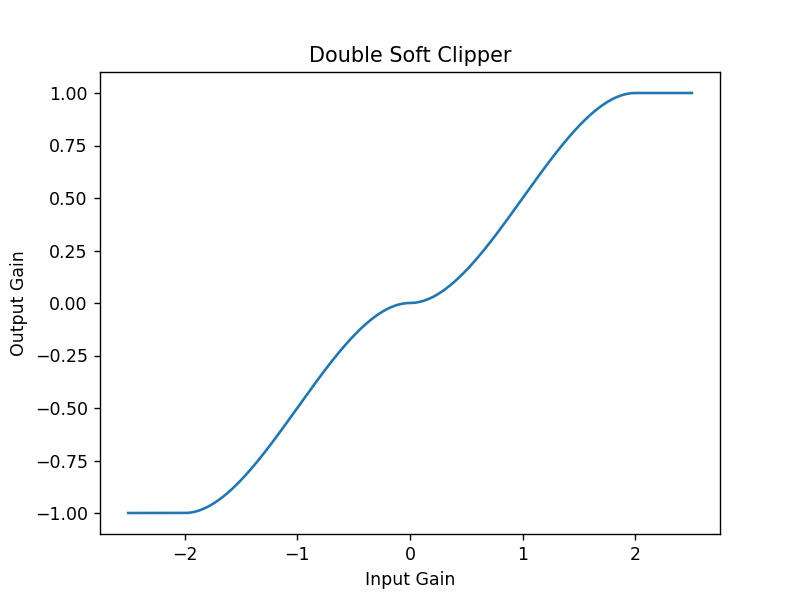

Text(0.5, 1.0, 'Double Soft Clipper')

In [3]:
def DoubleSoftClipper (x, upperLim, lowerLim, slope, xOffFactor, upperSkew, lowerSkew):
    xOff = (1/slope) * (slope)**xOffFactor
    
    if (x > 0):
        x = (x - xOff)*upperSkew
        if (x >= 1/slope):
            return upperLim
        elif (x <= -1/slope):
            return 0
        else:
            return (3/2) * upperLim * (slope*x - (slope*x)**3 / 3) / 2 + (upperLim/2)
    else:
        x = (x + xOff)*lowerSkew
        if (x >= 1/slope):
            return 0
        elif (x <= -1/slope):
            return lowerLim
        else:
            return (3/2) * -lowerLim * (slope*x - (slope*x)**3 / 3) / 2 + (lowerLim/2)
        
def plotDoubleSoftClipper(xRange=2, upperLim=1, lowerLim=-1, slope=1, xOffFactor=1, upperSkew=1, lowerSkew=1):
    N = 1000
    x = np.linspace (-xRange, xRange, N)
    y = np.zeros (N)
    
    n = 0
    for n in range (N):
        y[n] = DoubleSoftClipper (x[n], upperLim, lowerLim, slope, xOffFactor, upperSkew, lowerSkew)
        
    plt.plot (x, y)
    plt.xlabel ('Input Gain')
    plt.ylabel ('Output Gain')
    
plt.figure()
plotDoubleSoftClipper (xRange=2.5)
plt.title ('Double Soft Clipper')

I quickly realized that this function has the potential to be modulated in several interesting ways. I'll explore several of them below.

### Upper and Lower Limits
One interesting aspect of the double soft clipper is that you can control independently at what levels the top and bottom parts of the waveform begin to clip, which can give your nonlinearity some interesting asymmetry without introducing DC noise as some asymmetric non-linearities are wont to do.

<IPython.core.display.Javascript object>


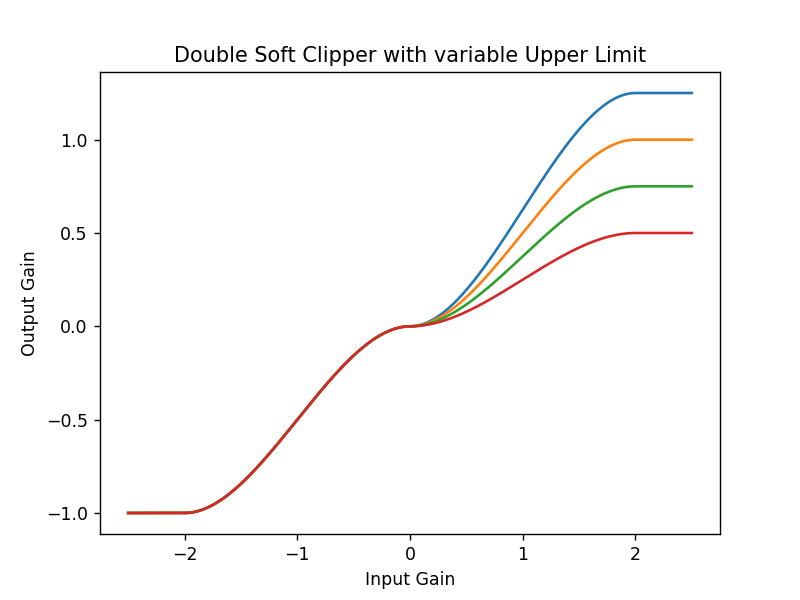

Text(0.5, 1.0, 'Double Soft Clipper with variable Upper Limit')

In [4]:
plt.figure()
for upper in [1.25, 1, 0.75, 0.5]:
    plotDoubleSoftClipper (xRange=2.5, upperLim=upper)
plt.title ('Double Soft Clipper with variable Upper Limit')

### Slope
You can also control the slope of the linear parts of the curve.

<IPython.core.display.Javascript object>


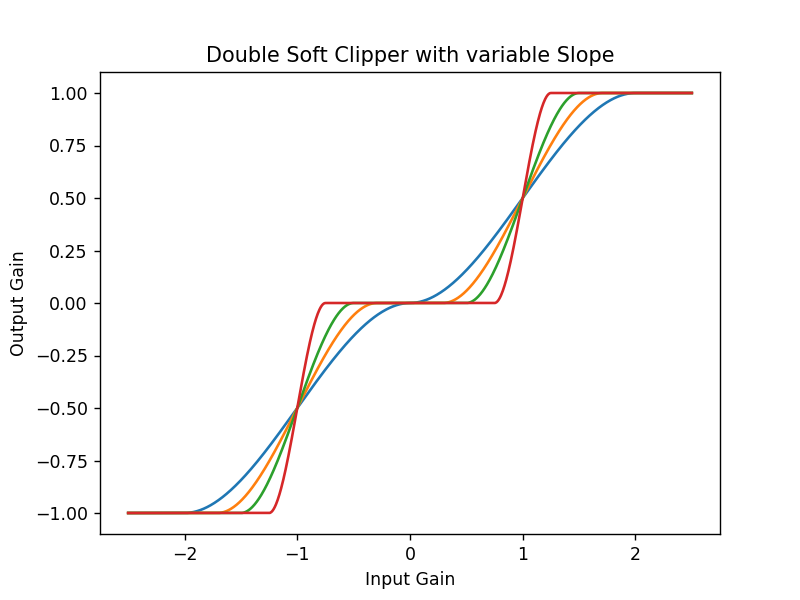

Text(0.5, 1.0, 'Double Soft Clipper with variable Slope')

In [5]:
plt.figure()
for slope in [1, np.sqrt(2), 2, 4]:
    plotDoubleSoftClipper (xRange=2.5, slope=slope)
plt.title ('Double Soft Clipper with variable Slope')

You can even indendently control the slopes of the upper and lower parts of the curve by *skewing* them

<IPython.core.display.Javascript object>


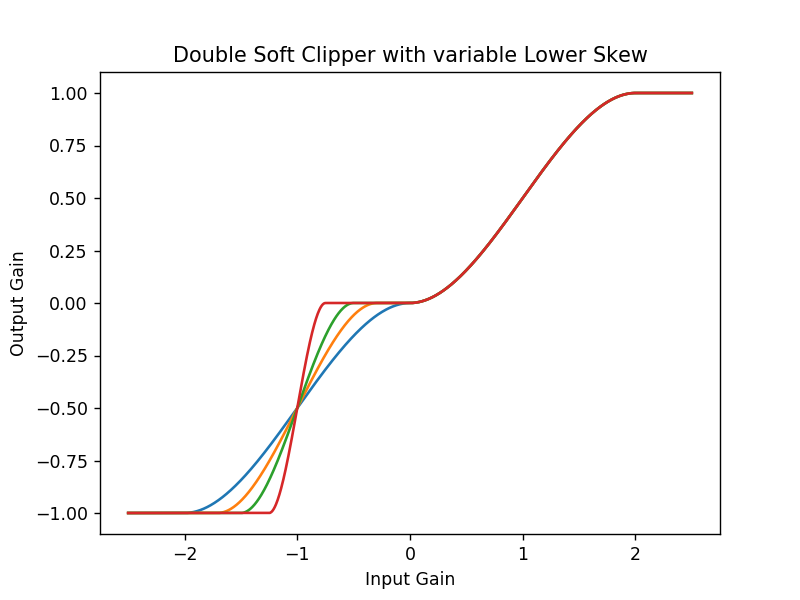

Text(0.5, 1.0, 'Double Soft Clipper with variable Lower Skew')

In [6]:
plt.figure()
for skew in [1, np.sqrt(2), 2, 4]:
    plotDoubleSoftClipper (xRange=2.5, lowerSkew=skew)
plt.title ('Double Soft Clipper with variable Lower Skew')

### Dropout Width
Finally, you can control the width of the dropout zone. Note that for this to work, slope must be greater than 1, and you can never make the dropout width smaller than $\frac{1}{\texttt{slope}}$

<IPython.core.display.Javascript object>


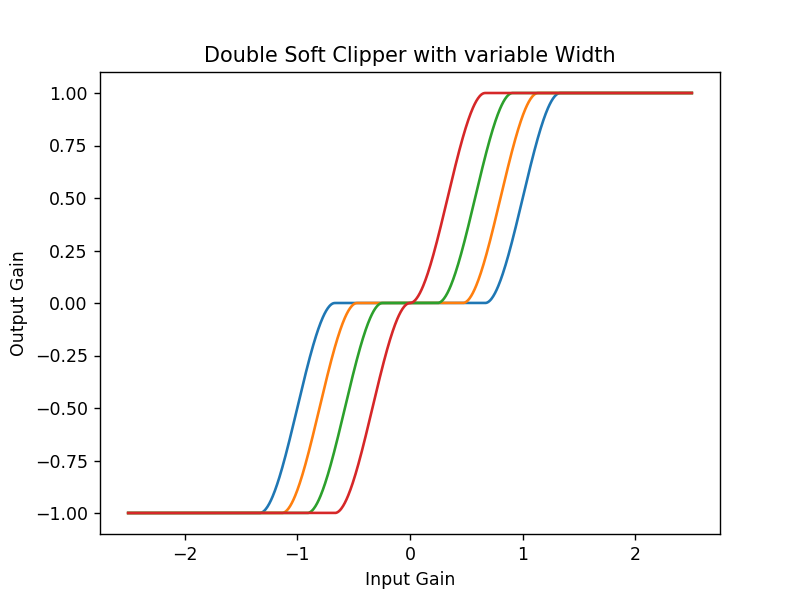

Text(0.5, 1.0, 'Double Soft Clipper with variable Width')

In [20]:
plt.figure()
for d in [1, 0.8, 0.5, 0]:
    plotDoubleSoftClipper (xRange=2.5, slope=3, xOffFactor=d)
plt.title ('Double Soft Clipper with variable Width')

With all these parameters available, you can get some really interesting shapes:

<IPython.core.display.Javascript object>


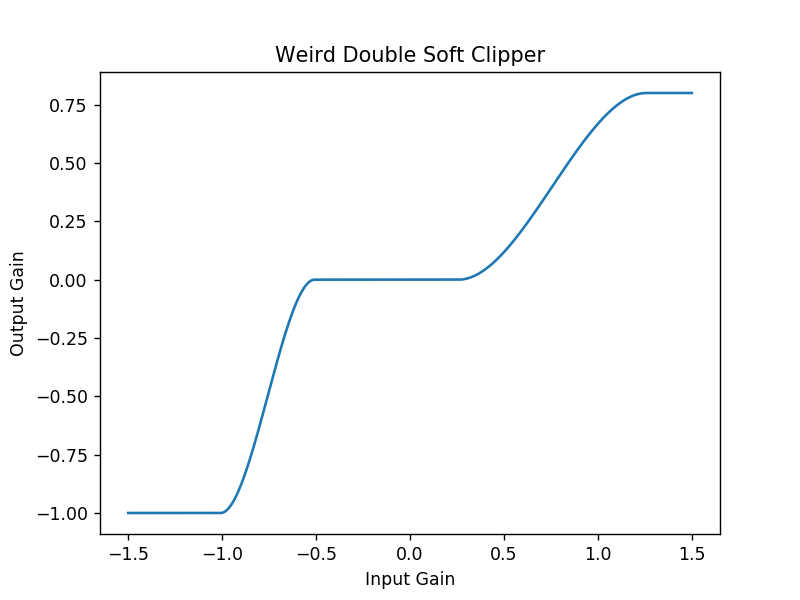

Text(0.5, 1.0, 'Weird Double Soft Clipper')

In [8]:
plt.figure()
plotDoubleSoftClipper (xRange=1.5, slope=2, upperLim=0.8, lowerSkew=2, xOffFactor=0.6)
plt.title ('Weird Double Soft Clipper')

<IPython.core.display.Javascript object>


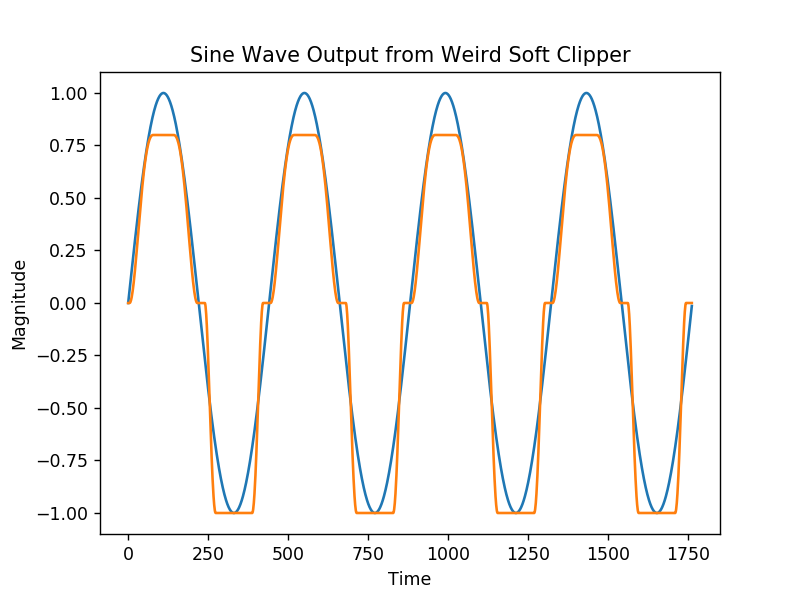

Text(0.5, 1.0, 'Sine Wave Output from Weird Soft Clipper')

In [18]:
def SineResponse (N=int(44100/25), gain=1):
    n = np.arange (N)
    x = np.sin (2 * np.pi * n * 100 / 44100)

    y= np.zeros (N)
    for t in range (N):
        y[t] = DoubleSoftClipper (gain*x[t], slope=2, upperLim=0.8, lowerLim=-1, upperSkew=1, lowerSkew=2, xOffFactor=0.2)
        
    return x, y

x, y = SineResponse(gain=1.2)
plt.figure()
plt.plot (x)
plt.plot (y)
plt.xlabel ('Time')
plt.ylabel ('Magnitude')
plt.title ('Sine Wave Output from Weird Soft Clipper')

## Aliasing Response

We should also examine the frequency response of this nonlinearity when the input is a 100 Hz sine wave, to understand what level of aliasing we might be dealing with. For this example we use the same shape as the "Weird Double Soft Clipper" above.

<IPython.core.display.Javascript object>


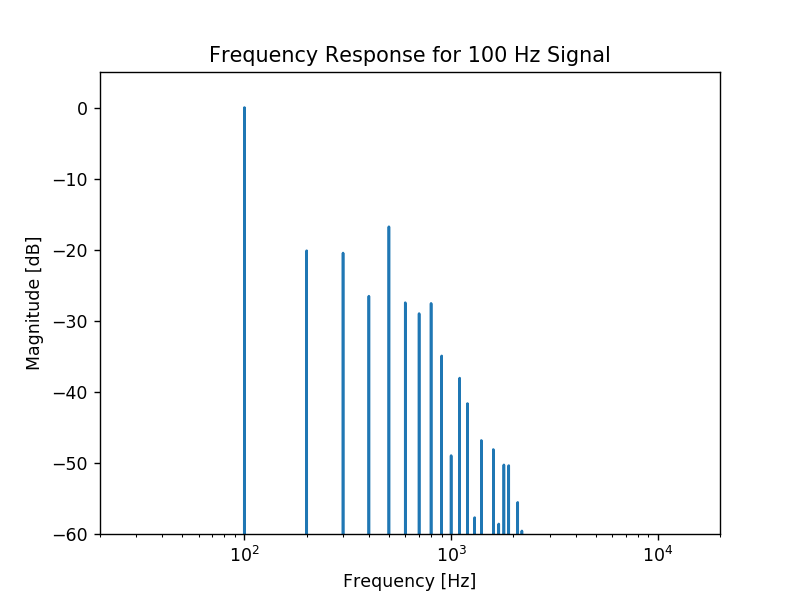

Text(0, 0.5, 'Magnitude [dB]')

In [21]:
N = 44100
x, y = SineResponse (N)

Y = np.fft.rfft (y)
Y = Y / np.max (np.abs (Y))
f = np.linspace (0, 44100/2, int(N/2+1))

plt.figure()
plt.semilogx (f, 20*np.log10 (np.abs (Y)))
plt.xlim (20, 20000)
plt.ylim (-60, 5)
plt.title ('Frequency Response for 100 Hz Signal')
plt.xlabel ('Frequency [Hz]')
plt.ylabel ('Magnitude [dB]')

So at first glance, this response does not look good. At 100 Hz, the double soft clipper gives back frequencies up past 2 kHz. This result implies that we would need more than 20x oversampling to completely eradicate aliasing artifacts down to -60 dB.

Now this may seem unexpected at first, given that all our nonlinearities are cubic. Shouldn't we need ~3x oversampling? Even though our nonlinearities are cubic, and the piecewise functions that make up the soft clippers are all continuous with continuous first derivatives, as with the normal soft clipper, there are discontinuities in the second derivatives. And since the double soft clipper contains approximately twice as many piecewise sections as the normal soft clipper, we are going to see more high frequency content.

There are several ways to approach this issue, but I highly recommend using antiderivative anti-aliasing, as described in recent DAFx papers by Julian Parker et. al, and Martin Holters. Because we know the the Double Soft Clipping nonlinear function in closed form, and we can quickly calculate its antiderivative, this method makes a lot of sense.

The implementation is super simple: For our nonlinear function $f(x(n))$, and the anti-derivative of that function $F(x(n))$, the ouput can be determined by

$$ y(n) = \begin{cases}
            \frac{F(x(n)) - F(x(n-1))}{x(n) - x(n-1)} & x(n) \neq x(n-1) \\
            f \left(\frac{1}{2}x(n) + \frac{1}{2}x(n-1) \right) & x(n) \approx x(n-1)
          \end{cases} $$

With this implementation, no aliasing will occur! However, it is still recommended to run at 2x the sample rate or higher because of frequency response concerns. More information can be found in the papers below.

Cite Parker

Cite Holters